In [1]:
def reddit_link(row):
    return f"https://reddit.com/{row['reddit_id']}"

In [2]:
import sys
sys.path
sys.path.append('/home/sapristi/dev/fleebmarket/advert_parsing/')

In [3]:
from pydantic import BaseModel, validator
import pandas as pd
import more_itertools
from enum import Enum
from typing import Optional
import re
import ipywidgets as ipw
from collections import defaultdict
from dataclasses import dataclass


from markdown_parser.custom_ast import Text, Break, Heading, Listing, Table, Ast, Item, Paragraph, TextAst
from markdown_parser import md_to_ast
from classification_utils.prices import find_in_tree, find_prices_in_text, find_price_wo_curr_in_text

In [4]:
try:
    data_full = pd.read_pickle('adverts_parsed.pickle')
except FileNotFoundError:
    data_full = pd.read_csv('adverts.csv').drop_duplicates(subset=['full_text'], keep='last')
    data_full['ast'] = data_full['full_text'].apply(md_to_ast)
    data_full.to_pickle('adverts_parsed.pickle')
    
data_full['ast']

0       children=[Paragraph(children=[Text(text='GMK D...
1       children=[Paragraph(children=[Text(text='Hello...
2       children=[Paragraph(children=[Text(text='Times...
3       children=[Paragraph(children=[Text(text='Times...
4       children=[Paragraph(children=[Text(text='TIMES...
                              ...                        
9995    children=[Paragraph(children=[Text(text='Times...
9996    children=[Paragraph(children=[Text(text='Times...
9997    children=[Paragraph(children=[Text(text='Howdy...
9998    children=[Paragraph(children=[Text(text='Times...
9999    children=[Paragraph(children=[Text(text='times...
Name: ast, Length: 9899, dtype: object

In [5]:
def clean_table(table: Table):
    ok_rows = []
    for row in table.rows:
        if any(row):
            ok_rows.append(row)
    
    return Table(rows=ok_rows)
def extract_tables(item: Item):
    if isinstance(item, Table):
        return [item]
    elif (
        isinstance(item, Ast) or
        isinstance(item, Listing) or 
        isinstance(item, Paragraph)
    ):
        
        extracted_tables_lists = [extract_tables(child) for child in item.children]
        tables = [clean_table(t) for tables in extracted_tables_lists for t in tables if tables is not None]
        return tables
#         return item.recurse(lambda items: [extract_tables(item) for item in items if item is not None])
    else:
        return []
    

In [6]:
data_full['has_table'] = data_full['ast'].apply(lambda item: len(extract_tables(item)) > 0)

In [7]:
data_full = data_full[~data_full['has_table']].drop('has_table', axis="columns")
data_full

,reddit_id,ad_type,full_text,ast
1,ngm8a4,Sold,Hello everyone! All shipping and fees are incl...,children=[Paragraph(children=[Text(text='Hello...
2,nb5fp4,Selling,Timestamp: https://imgur.com/a/CtIzhIw\n\nSell...,children=[Paragraph(children=[Text(text='Times...
5,ngm9qo,Selling,https://imgur.com/a/lMBDhmL\nAsking 315+Shippi...,children=[Paragraph(children=[Text(text='https...
8,ncn2ew,Sold,#[Timestamp](https://i.imgur.com/WmVhwo1.jpg)\...,children=[Heading(children=[Text(text='Timesta...
10,ocn8rv,Selling,http://imgur.com/a/ivn2Jth\n\nAll items are Br...,children=[Paragraph(children=[Text(text='http:...
...,...,...,...,...
9995,ngg4op,Selling,[Timestamp](https://imgur.com/a/5Q83uhL)\n\nHi...,children=[Paragraph(children=[Text(text='Times...
9996,odkhfa,Selling,[Timestampu](http://imgur.com/a/ZgQS6Hs)\n\nHe...,children=[Paragraph(children=[Text(text='Times...
9997,oj6e6h,Selling,[Howdystamp](https://imgur.com/a/TkdzBWM)\n\nC...,children=[Paragraph(children=[Text(text='Howdy...
9998,oqofnq,Selling,[Timestamp](https://imgur.com/a/vENEOE4)\n\n\n...,children=[Paragraph(children=[Text(text='Times...


In [8]:
data_full['nb_prices'] = data_full['ast'].apply(lambda ast: len(find_in_tree(find_prices_in_text)(ast)))

<AxesSubplot:>

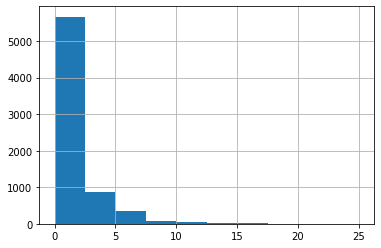

In [9]:
data_full['nb_prices'].hist()

<AxesSubplot:>

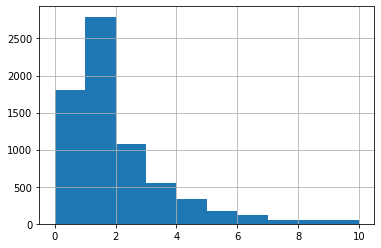

In [10]:
data_full[data_full['nb_prices'] <= 10]['nb_prices'].hist()

<AxesSubplot:>

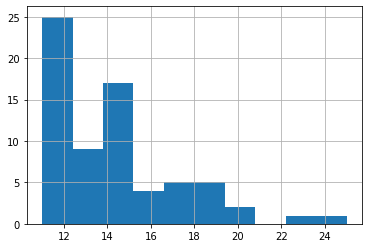

In [11]:
data_full[data_full['nb_prices'] > 10]['nb_prices'].hist()

In [12]:
def split_paragraph(paragraph):
    res = []
    current_res = []
    for child in paragraph.children:
        if child == Break.LineBreak:
            if current_res:
                res.append(TextAst(children=current_res))
        else:
            current_res.append(child)
    return res

def find_items_with_price(ast, res):
    nb_prices = len(find_in_tree(find_prices_in_text)(ast))
    match ast, nb_prices:
        case Text(text=_), _:
            res.append(ast)

        case Paragraph(children=_), _:
            split_parag = split_paragraph(ast)
            res.extend(split_parag)

        case (Listing(children=children) | Ast(children=children), _):
            for child in children:
                find_items_with_price(child, res)
                
        case _, 0:
            return
        
        case Heading(children=_), _:
            res.append(ast)
        
        case _, _:
            print("Something wrong?", nb_prices, ast.__class__.__name__)
            raise

In [13]:
def apply_find_items_w_price(ast):
    res = []
    find_items_with_price(ast, res)
    return res

data_full['pitems'] = data_full['ast'].apply(apply_find_items_w_price)

In [14]:
def apply_find_items_w_price(ast):
    res = []
    find_items_with_price(ast, res)
    return res

data_full['pitems'] = data_full['ast'].apply(apply_find_items_w_price)

In [15]:
for pitems in data_full['pitems']:
    for pitem in pitems:
        prices = find_in_tree(find_prices_in_text)(pitem)
        if len(prices) == 3:
            print(pitem)
            print()
            print(prices)
            print()
            print()

text='SA Granite : Both sets (ortho and TKL) have not been used. Base kit € 50, ortho kit € 30. Will bundle them for € 70' striked=False

[PriceTag(currency=<Currency.EUR: 'EUR'>, amount=50.0, striked=False), PriceTag(currency=<Currency.EUR: 'EUR'>, amount=30.0, striked=False), PriceTag(currency=<Currency.EUR: 'EUR'>, amount=70.0, striked=False)]


text='Walnut case for Anne Pro 2 EUR 45,5/USD 55' striked=False

[PriceTag(currency=<Currency.EUR: 'EUR'>, amount=45.5, striked=False), PriceTag(currency=<Currency.EUR: 'EUR'>, amount=2.0, striked=False), PriceTag(currency=<Currency.USD: 'USD'>, amount=55.0, striked=False)]


text="All Lividity puppeteers will be 60 USD (normally 78ish), that's 840 USD total for the 14, but you can take the lot for a discounted 700 USD or will consider trades towards Glyco caps or Badlucks, and jAnuses specifically." striked=False

[PriceTag(currency=<Currency.USD: 'USD'>, amount=60.0, striked=False), PriceTag(currency=<Currency.USD: 'USD'>, amount=840.0, st